# 04 — Third Model — Whisper Fine-Tune

**Status:** Working baseline — converges and transcribes vocal-only segments reliably; used as the final model for deliverables.

This notebook represents the submission version of the project.  
The original idea was to begin with this fine-tuned model on vocal-only stems and then gradually introduce the background instruments (other stems) during training, with the ultimate goal of transcribing lyrics directly from fully mixed audio.  
That extension was not pursued here, as it would have gone far beyond the original project scope.



# Prepare Environment

## 1. Mount Drive
Mount Google Drive (only needed in Colab).



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

## 2. Install Required Libraries


In [ ]:
try:
    import google.colab
    from IPython import get_ipython
    ip = get_ipython()
    ip.system("pip install transformers datasets torchaudio evaluate jiwer --quiet")
except Exception:
    print("Skipping pip installs (not in Colab).")


## 3. Import packages
Load all Python libraries used later.




In [ ]:
# Imports
import pandas as pd
import torch
from datasets import Dataset, load_dataset, Audio
from transformers import WhisperProcessor, WhisperForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments
import torchaudio
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import os
from datetime import datetime

## 4. Set paths
Define project root and subfolders (change `ROOT` to your clone path).

In [ ]:
# Cell — Config paths (Notebook 2: model training)
import os, sys
from pathlib import Path

# detect if running in Colab
IN_COLAB = "google.colab" in sys.modules

# CONFIG: project root folder
# Change this path to the folder where you cloned/downloaded the repo
ROOT = Path("/content/drive/MyDrive/GitHub/musdb18-asr-dl") if IN_COLAB else Path.cwd()

# canonical subfolders
DATA_RAW        = ROOT / "data" / "raw"
DATA_PROCESSED  = ROOT / "data" / "processed"
CHECKPOINTS_DIR = ROOT / "checkpoints" / 'Whisper_finetune'
RESULTS         = ROOT / 'results'
MODELS_DIR      = RESULTS / 'models' / 'Whisper_finetune'
RESULTS.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)


# Hugging Face cache (persistent if on Colab + Drive)
HF_CACHE = Path(
    os.environ.get(
        "HF_CACHE",
        "/content/drive/MyDrive/hf_cache" if IN_COLAB else (Path.home() / ".cache" / "huggingface")
    )
)
os.environ["HF_HOME"] = str(HF_CACHE)
os.environ["HF_DATASETS_CACHE"] = str(HF_CACHE)
os.environ["TRANSFORMERS_CACHE"] = str(HF_CACHE)

# ensure dirs exist
for d in [DATA_RAW, DATA_PROCESSED, OUT_DIR, CHECKPOINTS_DIR, LOGS_DIR, HF_CACHE]:
    d.mkdir(parents=True, exist_ok=True)

# quick printout
print("ROOT         :", ROOT)
print("DATA_RAW     :", DATA_RAW)
print("DATA_PROCESSED:", DATA_PROCESSED)
print("CHECKPOINTS  :", CHECKPOINTS_DIR)
print("HF_CACHE     :", HF_CACHE)


# Data prep

## load Whisper processor + model + Config

In [ ]:
MODEL_NAME = "openai/whisper-small"  # change to "tiny" if RAM is limited
RUN_NAME = f"whisper-finetune{datetime.now().strftime('%Y%m%d-%H%M')}"

OUTPUT_DIR = CHECKPOINTS_DIR / RUN_NAME
SAVE_DIR_LOCAL = f"./whisper-finetuned/{RUN_NAME}"
LOGGING_DIR = f"{OUTPUT_DIR}/logs"

processor = WhisperProcessor.from_pretrained(MODEL_NAME, language="en", task="translate")
model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME)

# Enable attention mask and force BOS\EOS token
model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="en", task="translate")
model.config.suppress_tokens = []


## Load training data and filter

In [ ]:
df = pd.read_csv(DATA_PROCESSED / "train_segments_vocal_combined.csv")
df = df[df["has_lyrics"] == True].copy()
df = df[["chunk_path", "Lyric"]].rename(columns={"chunk_path": "audio", "Lyric": "text"})
df = df.dropna(subset=["text", "audio"])
df = df.reset_index(drop=True)

## Data preprocess



In [ ]:
# Audio processing function

def preprocess_batch(batch):
    audio, _ = torchaudio.load(batch["audio"])
    audio = torchaudio.functional.resample(audio, orig_freq=44100, new_freq=16000)

    # Run processor ONCE with all desired options
    processed = processor(
        audio.squeeze().numpy(),
        sampling_rate=16000,
        return_attention_mask=True,
        return_tensors="pt",
        language="en",
        task="translate"
    )

    # Extract features and attention mask
    batch["input_features"] = processed.input_features[0]
    batch["attention_mask"] = processed.attention_mask[0]

    # Add EOS token to labels
    input_ids = processor.tokenizer(batch["text"]).input_ids
    input_ids.append(processor.tokenizer.eos_token_id)
    batch["labels"] = input_ids

    return batch


In [ ]:
# Convert data to Hugging Face Dataset
ds = Dataset.from_pandas(df)
ds = ds.map(preprocess_batch, remove_columns=["audio", "text"], num_proc=4)

# Save the processed Dataset to Drive
ds.save_to_disk(DATA_PROCESSED / "dataset_whisper_finetune")

# split to train and validation
ds = ds.train_test_split(test_size=0.1, seed=42)
train_ds = ds["train"]
val_ds = ds["test"]

# Model Config

## DataCollator

In [ ]:
@dataclass
class DataCollatorSpeechSeq2Seq:
    processor: WhisperProcessor

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        input_features = torch.tensor([f["input_features"] for f in features])

        # ✅ Convert to tensors before stacking
        attention_mask = torch.stack([
            torch.tensor(f["attention_mask"]) for f in features
        ])

        label_features = [torch.tensor(f["labels"]) for f in features]
        labels = torch.nn.utils.rnn.pad_sequence(
            label_features,
            batch_first=True,
            padding_value=self.processor.tokenizer.pad_token_id
        )
        labels[labels == self.processor.tokenizer.pad_token_id] = -100

        return {
            "input_features": input_features,
            "attention_mask": attention_mask,
            "labels": labels
        }


## WER and CER metrics

In [ ]:
import evaluate

wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)
    return {
        "wer": wer_metric.compute(predictions=pred_str, references=label_str),
        "cer": cer_metric.compute(predictions=pred_str, references=label_str)
    }

## Training Arguments

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    logging_dir=LOGGING_DIR,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    save_strategy="steps",
    save_steps=200,
    eval_strategy="steps",
    eval_steps=1000,
    logging_steps=100,
    num_train_epochs=10,
    gradient_accumulation_steps=2,
    warmup_steps=500,
    learning_rate=1e-5,
    predict_with_generate=True,
    fp16=True,
    save_total_limit=3,
    report_to=["tensorboard"],
    load_best_model_at_end=False,
    metric_for_best_model="wer",
    generation_max_length=128,
    generation_num_beams=1,
)

# Training

## Trainer

In [ ]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=DataCollatorSpeechSeq2Seq(processor),
    tokenizer=processor.tokenizer,
    compute_metrics=compute_metrics
)

## Train

In [ ]:
trainer.train(resume_from_checkpoint=True)

# Define save path in Google Drive
drive_save_path = OUTPUT_DIR

# Save both the model and processor
model.save_pretrained(drive_save_path)
processor.save_pretrained(drive_save_path)

print(f"✅ Model saved to Drive at: {drive_save_path}")


# Test

## Load test set

In [ ]:
test_df = pd.read_csv(DATA_PROCESSED / "test_segments_vocals_fixed.csv")
test_df = test_df[test_df["has_lyrics"] == True].copy()
test_df = test_df[["chunk_path", "Lyric"]].rename(columns={"chunk_path": "audio", "Lyric": "text"})
test_df = test_df.dropna(subset=["text", "audio"]).reset_index(drop=True)


## Preprocess test audio

In [ ]:
def preprocess_test(batch):
    audio, _ = torchaudio.load(batch["audio"])
    audio = torchaudio.functional.resample(audio, orig_freq=44100, new_freq=16000)

    processed = processor(
        audio.squeeze().numpy(),
        sampling_rate=16000,
        return_attention_mask=True,
        return_tensors="pt",
        language="en",
        task="translate"
    )

    batch["input_features"] = processed.input_features[0]
    batch["attention_mask"] = processed.attention_mask[0]

    # Add <eos> token to labels
    input_ids = processor.tokenizer(batch["text"]).input_ids
    input_ids.append(processor.tokenizer.eos_token_id)
    batch["labels"] = input_ids

    batch["reference_text"] = batch["text"]
    return batch


test_ds = Dataset.from_pandas(test_df)
test_ds = test_ds.map(preprocess_test, remove_columns=["audio", "text"], num_proc=1)

# Save the processed Dataset to Drive
test_ds.save_to_disk(DATA_PROCESSED / "test_ds_whisper_finetune")


# Predict

## Make predictions

In [ ]:
test_outputs = trainer.predict(test_dataset=test_ds)

## Decode predictions and references

In [ ]:
pred_ids = test_outputs.predictions
label_ids = test_outputs.label_ids
pred_strs = processor.batch_decode(pred_ids, skip_special_tokens=True)

# Decode references, replacing -100 with pad token
label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
label_strs = processor.batch_decode(label_ids, skip_special_tokens=True)


# Evaluate (WER / CER)

In [ ]:
test_wer = wer_metric.compute(predictions=pred_strs, references=label_strs)
test_cer = cer_metric.compute(predictions=pred_strs, references=label_strs)

print(f"\n📊 Final Evaluation on Test Set:")
print(f"WER: {test_wer:.4f}")
print(f"CER: {test_cer:.4f}")


📊 Final Evaluation on Test Set:
WER: 8.7536
CER: 8.4900


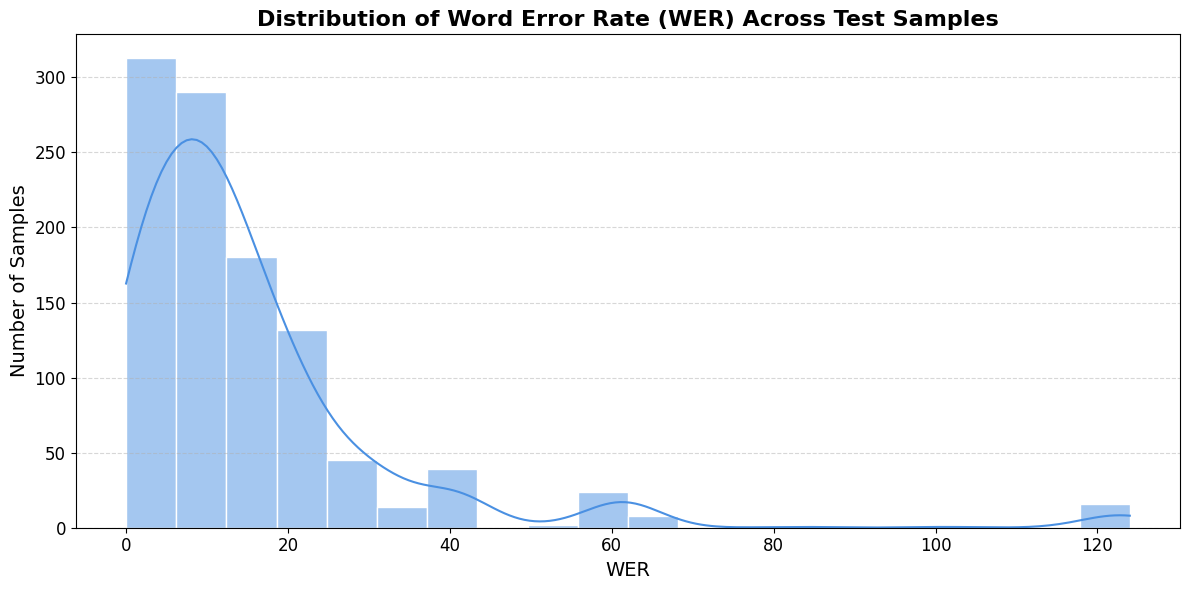

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from jiwer import wer

# Compute WERs
wer_scores = [wer(ref, pred) for ref, pred in zip(ref_strs, pred_strs)]

# Plot setup
plt.figure(figsize=(12, 6))
sns.histplot(wer_scores, bins=20, kde=True, color="#4A90E2", edgecolor='white')

# Style and labels
plt.title("Distribution of Word Error Rate (WER) Across Test Samples", fontsize=16, weight='bold')
plt.xlabel("WER", fontsize=14)
plt.ylabel("Number of Samples", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Print Ground Truth vs Predicted

In [ ]:
# Decode predictions and references
pred_ids = test_outputs.predictions
label_ids = test_outputs.label_ids

# Decode predicted text
pred_strs = processor.batch_decode(pred_ids, skip_special_tokens=True)

# Decode ground truth text (replace -100 with pad token ID)
label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
ref_strs = processor.batch_decode(label_ids, skip_special_tokens=True)

# Create DataFrame for easy display
import pandas as pd

results_df = pd.DataFrame({
    "Ground Truth": ref_strs,
    "Predicted": pred_strs
})

# Display first 20 rows for quick comparison
import IPython.display as display
display.display(results_df.head(20))


,Ground Truth,Predicted
0,take on big bite of life to go,take one big bite of life to go you are the on...
1,take an apple please from the front row,take an apple please from the front row you ar...
2,oh soon enough never good enough,was so enough never good enough you are so eno...
3,inch by inch come on connect the dots,inch by inch come on connect the dots inch by ...
4,yeah keep keep keep me in your line of sight s...,yeah keep keep keep me in your lines of squeez...
5,squeeze squeeze squeeze me go on hold me tight,squeeze squeeze squeeze me go on hold me tight...
6,tight close close close until you're kissable,me tight close close close to do your kiss abo...
7,get get gets you in my heart's peripheral,got got got you in my heart's broken roll got ...
8,toes in toes out i'm on stand by,toes in toes out i'm lost and by
9,now were testing out our wings for flight,yeah we're testing out our wings for flight ye...


## Ptint the Best Results

In [ ]:
from jiwer import wer, cer

# Build a list of (index, GT, prediction, WER, CER)
results = []

for i in range(len(ref_strs)):
    w = wer(ref_strs[i], pred_strs[i])
    c = cer(ref_strs[i], pred_strs[i])
    results.append((i, ref_strs[i], pred_strs[i], w, c))

# Sort by WER (ascending)
results_sorted = sorted(results, key=lambda x: x[3])

# Display top 20 lowest WER results
for i, gt, pr, w, c in results_sorted[:20]:
    print(f"Index: {i}")
    print(f"GT: {gt}")
    print(f"PR: {pr}")
    print(f"WER: {w:.3f}")
    print(f"CER: {c:.3f}")
    print("-" * 60)


Index: 33
GT: for the time of my life
PR: for the time of my life
WER: 0.000
CER: 0.000
------------------------------------------------------------
Index: 61
GT: where will my heart come back to life
PR: where will my heart come back to life
WER: 0.000
CER: 0.000
------------------------------------------------------------
Index: 116
GT: sun is hiding beautiful black eyes
PR: sun is hiding beautiful black eyes
WER: 0.000
CER: 0.000
------------------------------------------------------------
Index: 122
GT: she met him last year at the local
PR: she met him last year at the local
WER: 0.000
CER: 0.000
------------------------------------------------------------
Index: 189
GT: i know that you can find me when i'm lost when i'm lost
PR: i know that you can find me when i'm lost when i'm lost
WER: 0.000
CER: 0.000
------------------------------------------------------------
Index: 191
GT: i'm feeling numb
PR: i'm feeling numb
WER: 0.000
CER: 0.000
-----------------------------------------

## Print the Worst Results

In [ ]:
from jiwer import wer, cer

# Build list of (index, GT, prediction, WER, CER)
results = []

for i in range(len(ref_strs)):
    w = wer(ref_strs[i], pred_strs[i])
    c = cer(ref_strs[i], pred_strs[i])
    results.append((i, ref_strs[i], pred_strs[i], w, c))

# Sort by WER (descending)
results_sorted = sorted(results, key=lambda x: x[3], reverse=True)

# Display top 20 worst WER results
for i, gt, pr, w, c in results_sorted[:20]:
    print(f"Index: {i}")
    print(f"GT: {gt}")
    print(f"PR: {pr}")
    print(f"WER: {w:.3f}")
    print(f"CER: {c:.3f}")
    print("-" * 60)


Index: 96
GT: bulldozer
PR: burn those who are left behind burn those who are left behind burn those who are left behind burn those who are left behind burn those who are left behind burn those who are left behind burn those who are left behind burn those who are left behind burn those who are left behind burn those who are left behind burn those who are left behind burn those who are left behind burn those who are left behind burn those who are left behind burn those who are left behind burn those who are left behind burn those who are left behind burn those who are left behind burn those who are left behind burn those who are left behind burn those who are
WER: 124.000
CER: 70.000
------------------------------------------------------------
Index: 350
GT: ha
PR: oh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh uh 

## Print Random Results

In [ ]:
from jiwer import cer, wer

for i in range(20):
    print(f"GT: {ref_strs[i]}")
    print(f"PR: {pred_strs[i]}")
    print(f"WER: {wer(ref_strs[i], pred_strs[i]):.3f}")
    print(f"CER: {cer(ref_strs[i], pred_strs[i]):.3f}")
    print("-" * 60)

GT: take on big bite of life to go
PR: take one big bite of life to go you are the one you need i'm not worried you're not worried i'm not worried you're not worried i'm not worried you're not worried i'm not worried you're not worried i'm not worried you're not worried i'm not worried you're not worried i'm not worried you're not worried i'm not worried you're not worried i'm not worried you're not worried i'm not worried you're not worried i'm not worried you're not worried i'm not worried you're not worried i'm not worried you're not worried i'm not worried you're
WER: 11.125
CER: 16.800
------------------------------------------------------------
GT: take an apple please from the front row
PR: take an apple please from the front row you are the one you need i'm not worried you are the one you need i'm not worried you are the one you need i'm not worried you are the one you need i'm not worried you are the one you need i'm not worried you are the one you need i'm not worried you are